In [144]:
import numpy as np
import matplotlib.pyplot as plt
mu=0.5
a=0.3
r=2
theta_0=np.pi
omega=1
phi_1=np.pi/2
phi_2=0
d_0=3
d=1
d_theta=np.pi/6
def theta_1(t):
    return theta_0+d_theta*np.sin(omega*t+phi_1)
def Dot_theta_1(t):
    return omega*d_theta*np.cos(omega*t+phi_1)
def L2(t):
    return d_0+d*np.cos(omega*t+phi_1)
def Dot_L2(t):
    return -omega*d*np.sin(omega*t+phi_1)
def L1(t):
    return d_0+d*np.cos(omega*t+phi_2)
def Dot_L1(t):
    return -omega*d*np.sin(omega*t+phi_2)
def oseen_tensor(r_i):
    G = np.zeros((3,3,2,2))
    D=1/(6*np.pi*mu*a)*np.eye(2)
    G[0,0]=G[1,1]=G[2,2]=D
    def off_diag(i,j):
        r_ij = r_i[i]-r_i[j]
        norm=np.linalg.norm(r_ij)
        hat_r_ij = r_ij/norm
        return 1/(8*np.pi*mu*norm)*(np.eye(2)+np.outer(hat_r_ij,hat_r_ij))
    G[0,1]=G[1,0]=off_diag(0,1)
    G[0,2]=G[2,0]=off_diag(0,2)
    G[1,2]=G[2,1]=off_diag(1,2)
    return G
def r_ij(t):
    return np.array([[L1(t),0,L2(t)*np.cos(theta_1(t))],
                     [0,    0,L2(t)*np.sin(theta_1(t))]])
initial_position=r_ij(0)

In [146]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython.display as display
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
plt.gca().set_aspect('equal')
time=np.linspace(0,20,200)
def animate(i):
    ax.clear()
    # Get the point from the points list at index i
    # Plot that point using the x and y coordinates
    initial_position=r_ij(time[i])
    ax.scatter(initial_position[0],initial_position[1], color='black', marker='o')
    #ax.add_patch(plt.Circle(initial_position[:,0], a, color='black', fill=False))
    #ax.add_patch(plt.Circle(initial_position[:,1], a, color='black', fill=False))
    #ax.add_patch(plt.Circle(initial_position[:,2], a, color='black', fill=False))
    ax.plot([initial_position[0,0],0], [initial_position[1,0], 0], color='black')
    #ax.plot([initial_position[0,1], 0], [initial_position[1,1], 0], color='black')
    ax.plot([initial_position[0,2], 0], [initial_position[1,2], 0], color='black')
    # Set the x and y axis to display a fixed range
    ax.set_xlim([-2*d_0,2*d_0])
    ax.set_ylim([-2*d_0, 2*d_0])
    
ani = FuncAnimation(fig, animate, frames=len(time),
                    interval=10, repeat=False)
plt.close()
# embedding for the video 
html = display.HTML(ani.to_jshtml()) 
  
# draw the animation 
display.display(html) 
plt.close() 

In [147]:
Num_frame=200
time=np.linspace(0,20,Num_frame)
r_i=np.zeros((3,2,Num_frame))
r_i[:,:,0]=initial_position.T
v_c=np.zeros((2,Num_frame))
phi_i_dot=np.zeros((2,Num_frame))
phi_i=np.zeros((2,Num_frame))
phi_i[0,0]=0
phi_i[1,0]=theta_1(0)
def friction(r_i,t):
    A=np.zeros((6,6))
    b=np.zeros(6)
    A[0:2,0:2]=A[0:2,2:4]=A[0:2,4:6]=np.eye(2)
    #0    1    2    3    4    5   
    #F_1x F1y F_2x F_2y F_3x F_3y 
    A[2,0]=-r_i[0,1]
    A[2,1]= r_i[0,0]
    A[2,2]=-r_i[1,1]
    A[2,3]= r_i[1,0]
    A[2,4]=-r_i[2,1]
    A[2,5]= r_i[2,0]
    r_hat_1=(r_i[0,:]-r_i[1,:])/L1(time[t])
    r_hat_2=(r_i[2,:]-r_i[1,:])/L2(time[t])
    phi_hat_1=np.zeros_like(r_hat_1)
    phi_hat_2=np.zeros_like(r_hat_2)
    phi_hat_1[0]=-r_hat_1[1]
    phi_hat_1[1]= r_hat_1[0]
    phi_hat_2[0]=-r_hat_2[1]
    phi_hat_2[1]= r_hat_2[0]
    b[3]=Dot_L1(time[t])
    b[4]=Dot_L2(time[t])
    b[5]=-Dot_theta_1(time[t])
    G=oseen_tensor(r_i)
    A[3,0:2]=(G[0,0]-G[1,0])@r_hat_1
    A[3,2:4]=(G[0,1]-G[1,1])@r_hat_1
    A[3,4:6]=(G[0,2]-G[1,2])@r_hat_1
    A[4,0:2]=(G[2,0]-G[1,0])@r_hat_2
    A[4,2:4]=(G[2,1]-G[1,1])@r_hat_2
    A[4,4:6]=(G[2,2]-G[1,2])@r_hat_2
    A[5,0:2]=(G[0,0]-G[1,0])@phi_hat_1/L1(time[t])+(G[1,0]-G[2,0])@phi_hat_2/L2(time[t])
    A[5,2:4]=(G[0,1]-G[1,1])@phi_hat_1/L1(time[t])+(G[1,1]-G[2,1])@phi_hat_2/L2(time[t])
    A[5,4:6]=(G[0,2]-G[1,2])@phi_hat_1/L1(time[t])+(G[1,2]-G[2,2])@phi_hat_2/L2(time[t])
    solution=np.linalg.solve(A,b)
    v_c[:,t]=G[1,0]@solution[0:2]+G[1,1]@solution[2:4]+G[1,2]@solution[4:6]
    phi_i_dot[0,t]=np.dot(G[0,0]@solution[0:2]+G[0,1]@solution[2:4]+G[0,2]@solution[4:6]-v_c[:,t],phi_hat_1)/L1(time[t])
    phi_i_dot[1,t]=np.dot(G[2,0]@solution[0:2]+G[2,1]@solution[2:4]+G[2,2]@solution[4:6]-v_c[:,t],phi_hat_2)/L2(time[t])
    assert np.sum(solution[0:2]+solution[2:4]+solution[4:6])<1e-10 #Fnet 0
    assert np.cross(r_i[0,:],solution[0:2])+np.cross(r_i[1,:],solution[2:4])+np.cross(r_i[2,:],solution[4:6])<1e-10 #torque net 0
    assert Dot_L1(time[t])-(G[0,0]@solution[0:2]+G[0,1]@solution[2:4]+G[0,2]@solution[4:6]-v_c[:,t])@r_hat_1<1e-10
    assert Dot_L2(time[t])-(G[2,0]@solution[0:2]+G[2,1]@solution[2:4]+G[2,2]@solution[4:6]-v_c[:,t])@r_hat_2<1e-10
    
    #print(Dot_theta_1(time[t])-(phi_i_dot[1,t]-phi_i_dot[0,t]))
    return A

for t in range(Num_frame-1):
    friction(r_i[:,:,t],t)
    r_i[1,:,t+1]=r_i[1,:,t]+v_c[:,t]*(time[t+1]-time[t])
    phi_i[:,t+1]=phi_i[:,t]+phi_i_dot[:,t]*(time[t+1]-time[t])
    r_i[0,:,t+1]=r_i[1,:,t+1]+L1(time[t+1])*np.array([np.cos(phi_i[0,t+1]),np.sin(phi_i[0,t+1])])
    r_i[2,:,t+1]=r_i[1,:,t+1]+L2(time[t+1])*np.array([np.cos(phi_i[1,t+1]),np.sin(phi_i[1,t+1])])

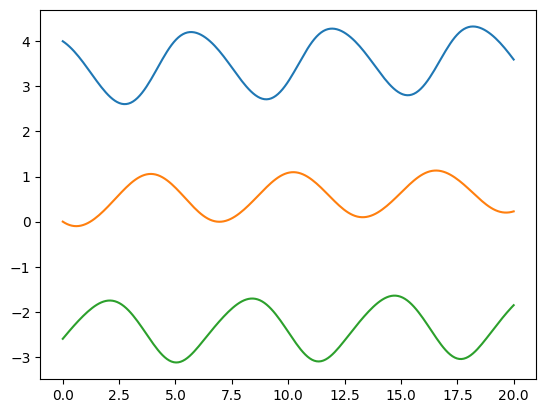

In [148]:
plt.plot(time,r_i[0,0],label='x1')
plt.plot(time,r_i[1,0],label='x2')
plt.plot(time,r_i[2,0],label='x2')

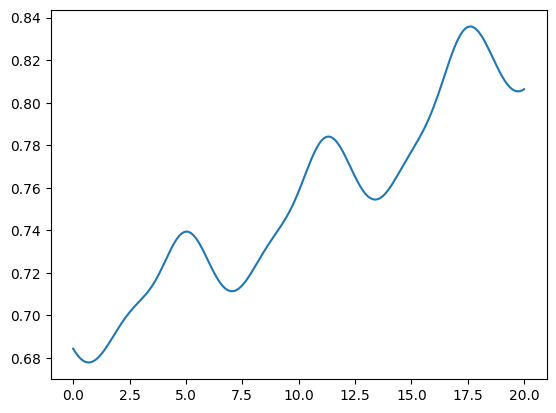

In [153]:
plt.plot(time,1/3*np.sqrt((r_i[0,0]+r_i[1,0]+r_i[2,0])**2+(r_i[0,1]+r_i[1,1]+r_i[2,1])**2),label='cm')

In [149]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython.display as display
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
plt.gca().set_aspect('equal')
def animate(i):
    ax.clear()
    # Get the point from the points list at index i
    # Plot that point using the x and y coordinates
    ax.scatter(r_i[:,0,i],r_i[:,1,i], color='black', marker='o')
    #ax.add_patch(plt.Circle(initial_position[:,0], a, color='black', fill=False))
    #ax.add_patch(plt.Circle(initial_position[:,1], a, color='black', fill=False))
    #ax.add_patch(plt.Circle(initial_position[:,2], a, color='black', fill=False))
    ax.plot([r_i[0,0,i],r_i[1,0,i]], [r_i[0,1,i],r_i[1,1,i]], color='black')
    ax.plot([r_i[2,0,i],r_i[1,0,i]], [r_i[2,1,i],r_i[1,1,i]], color='black')
    # Set the x and y axis to display a fixed range
    ax.set_xlim([-10,10])
    ax.set_ylim([-10,10])
    
ani = FuncAnimation(fig, animate, frames=len(time),
                    interval=10, repeat=False)
plt.close()
# embedding for the video 
html = display.HTML(ani.to_jshtml()) 
  
# draw the animation 
display.display(html) 
plt.close() 
ani.save('Tsang_motor.gif', writer='imagemagick', fps=30)

MovieWriter imagemagick unavailable; using Pillow instead.
